In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# Paths
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-1377"
test_img_dir = Path("/home/paster/LMY/data/general/split/test/images")
test_mask_dir = Path("/home/paster/LMY/data/general/split/test/mask")

# Load model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)




/home/paster/miniconda3/envs/segformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Collect image-mask pairs with non-empty masks
pairs = []
for mask_path in sorted(test_mask_dir.glob("*.png")):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None or np.sum(mask) == 0:
        continue
    image_name = mask_path.name.replace(".png", ".tif")
    image_path = test_img_dir / image_name
    if image_path.exists():
        pairs.append((image_path, mask_path))

print(f"✅ Found {len(pairs)} non-empty test pairs.")



✅ Found 59 non-empty test pairs.


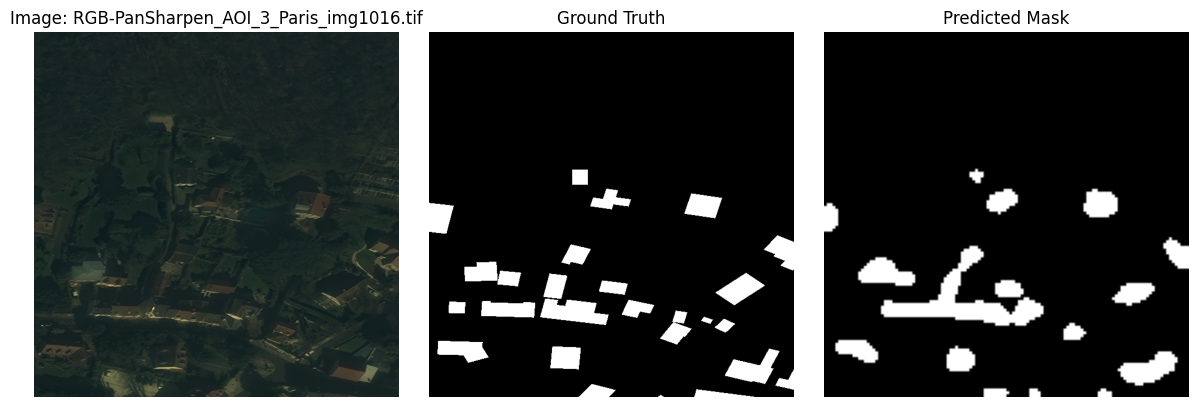

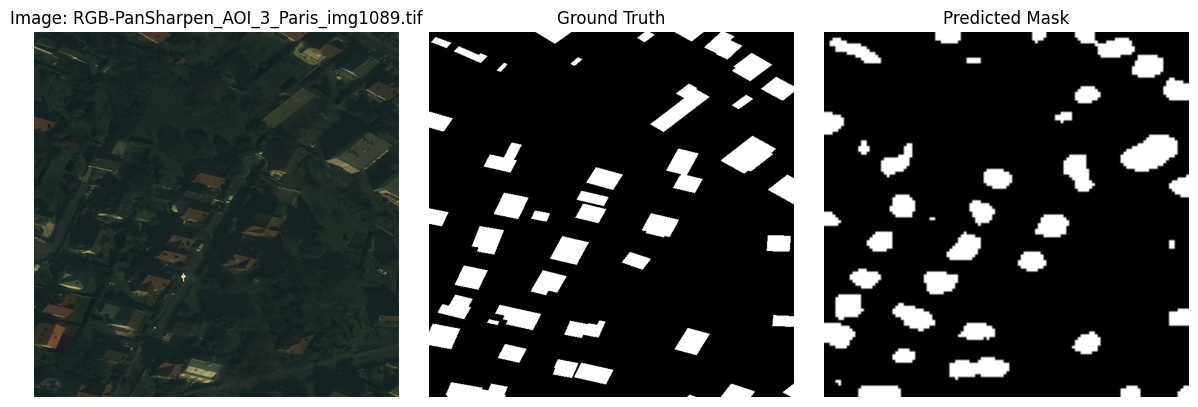

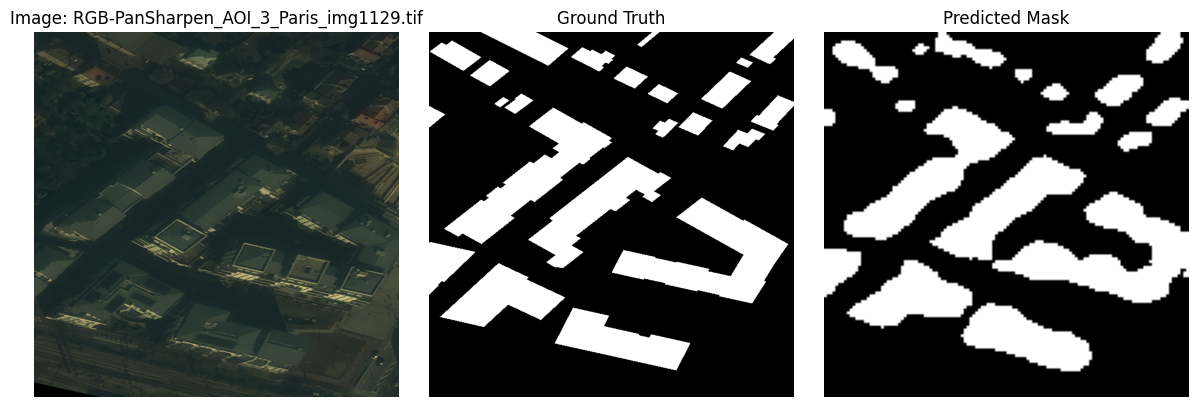

In [3]:
# Predict and visualize a few
n = min(3, len(pairs))
for i in range(n):
    img_path, mask_path = pairs[i]
    
    # Read image with rasterio
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image_uint8 = (image * 255).astype(np.uint8)
    
    # Process and run model
    inputs = processor(images=image_uint8, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    pred_mask = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()

    # Read ground-truth mask
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    # Show side by side
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image: {img_path.name}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()